## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [57]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
welly.__version__

'0.3.0'

In [2]:
%%timeit
import os
env = %env


10000 loops, best of 3: 97.2 µs per loop


In [2]:
from IPython.display import display

In [3]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

## We're going to load a pickle file of a previously created dataframe

### The dataframe merges:
1. picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
2. picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
3. wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
4. gis = pd.read_csv('../../well_lat_lng.csv')

### It also excludes any wells that have nulls or zeros for Top McMurray or Base McMurray picks
This was done in notebooks: 
1. notebooks_2018/mapmaking/Map_Exploration_v2-KDtree.ipynb
2. notebooks_2018/Test_RUN_2018_02/DataCleaningPrepof_KNN_neighborPickDepth_df_creation_vA_20180210

### Let's load in the pickle file of the dataframe from previous notebook mentioned above

In [4]:
wells_df_new_cleaned_plus_nn_wNoNulls =  pd.read_pickle('wells_df_new_cleaned_plus_nn_wNoNulls.p')

In [5]:
wells_df_new_cleaned_plus_nn_wNoNulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 0 to 2192
Data columns (total 16 columns):
SitID                                  1921 non-null int64
McMurray_Base_HorID                    1921 non-null int64
McMurray_Top_HorID                     1921 non-null int64
McMurray_Base_DEPTH                    1921 non-null float64
McMurray_Top_DEPTH                     1921 non-null float64
McMurray_Base_Qual                     1921 non-null int64
McMurray_Top_Qual                      1921 non-null int64
lat                                    1921 non-null float64
lng                                    1921 non-null float64
UWI                                    1921 non-null object
Neighbors_Obj                          1921 non-null object
NN1_McMurray_Top_DEPTH                 1921 non-null float64
NN1_McMurray_Base_DEPTH                1921 non-null float64
NN1_thickness                          1921 non-null float64
MM_Top_Depth_predBy_NN1thick           1921 non-nul

In [40]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0     [{'distance': 0.05753100195547899, 'neighbor': 1, 'UWI': '00/09-11-067-02W4/0'}, {'distance': 0.08749430324884858, 'neighbor': 2, 'UWI': '00/11-08-068-01W4/0'}, {'distance': 0.10451669032744222, 'neighbor': 3, 'UWI': '00/09-11-068-02W4/0'}, {'distance': 0.1099989647224123, 'neighbor': 4, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.14017282905400244, 'neighbor': 5, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.14539497462086076, 'neighbor': 6, 'UWI': '00/06-26-068-02W4/0'}, {'distance': 0.14676425482044453, 'neighbor': 7, 'UWI': '00/10-29-067-02W4/0'}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'distance': 0.04734000608365529, 'neighbor': 1, 'UWI': '00/10-29-067-02W4/0'}, {'distance': 0.07332213830078355, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.07725585850924727, 'neighbor': 3, 'UWI': '00/07-36-067-03W4/0'}, {'distance': 0.07846755926496476, 'neighbor': 4, 'UWI': '00/10-14-067-03W4/0'}, {'distance': 0.08267376663125782, 'neighbor': 5, 'UWI': '00/09-11-067-02W4/0'}, {'distance': 0.09089701215112062, 'neighbor': 6, 'UWI': '00/10-08-068-02W4/0'}, {'distance': 0.11681159403073145, 'neighbor': 7, 'UWI': '00/06-13-068-03W4/0'}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0    [{'distance': 0.05753100195547899, 'neighbor': 1, 'UWI': '00/12-08-067-01W4/0'}, {'distance': 0.06649378619088428, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.08267376663125782, 'neighbor': 3, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.08728400165551212, 'neighbor': 4, 'UWI': '00/09-11-068-02W4/0'}, {'distance': 0.09343691917544036, 'neighbor': 5, 'UWI': '00/10-29-067-02W4/0'}, {'distance': 0.10808166919974113, 'neighbor': 6, 'UWI': '00/11-08-068-01W4/0'}, {'distance': 0.12013967631468725, 'neighbor': 7, 'UWI': '00/10-08-068-02W4/0'}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'distance': 0.04355700607250212, 'neighbor': 1, 'UWI': '00/10-08-068-02W4/0'}, {'distance': 0.04589036401030715, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.04734000608365529, 'neighbor': 3, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.052016152587450945, 'neighbor': 4, 'UWI': '00/07-36-067-03W4/0'}, {'distance': 0.0789884047

In [41]:
print(len(wells_df_new_cleaned_plus_nn_wNoNulls))

1921


### Unfortunately, it seems we forgot pick quality, so we'll have to load the dataframe created in initial notebooks and merge only those characteristics

In [28]:
# picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
# picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
# picks_TopMcM=picks[picks['HorID']==13000]
# picks_paleoz=picks[picks['HorID']==14000]

In [29]:
# len(picks_paleoz)

2193

There are NAs in these, so we must take them out before merging

In [30]:
# pick_new_1400_1300 =pd.merge(picks_TopMcM, picks_paleoz, on='SitID')

In [31]:
# pick_new_1400_1300.head()

SitID  HorID_x Pick_x  Quality_x  HorID_y Pick_y  Quality_y
0  102496    13000    475          3    14000    561          1
1  102497    13000    515          3    14000  604.5          1
2  102498    13000    480          3    14000    564          1
3  102500    13000    549          3    14000  636.5          1
4  102501    13000    529          2    14000    613          1

In [35]:
# #### Take out rows with nulls in pick column or -1 in quality column that equals no pick for that row
# pick_new_1400_1300 = pick_new_1400_1300[pick_new_1400_1300['Pick_x'].notnull()]
# pick_new_1400_1300 = pick_new_1400_1300[pick_new_1400_1300['Quality_x'] != -1]
# pick_new_1400_1300 = pick_new_1400_1300[pick_new_1400_1300['Pick_y'].notnull()]
# pick_new_1400_1300 = pick_new_1400_1300[pick_new_1400_1300['Quality_y'] != -1]

In [36]:
# print(len(pick_new_1400_1300))

2164


### Merging the two dataframes

In [38]:
# df_new =pd.merge(pick_new_1400_1300, wells_df_new_cleaned_plus_nn_wNoNulls, on='SitID')

In [42]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0     [{'distance': 0.05753100195547899, 'neighbor': 1, 'UWI': '00/09-11-067-02W4/0'}, {'distance': 0.08749430324884858, 'neighbor': 2, 'UWI': '00/11-08-068-01W4/0'}, {'distance': 0.10451669032744222, 'neighbor': 3, 'UWI': '00/09-11-068-02W4/0'}, {'distance': 0.1099989647224123, 'neighbor': 4, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.14017282905400244, 'neighbor': 5, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.14539497462086076, 'neighbor': 6, 'UWI': '00/06-26-068-02W4/0'}, {'distance': 0.14676425482044453, 'neighbor': 7, 'UWI': '00/10-29-067-02W4/0'}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'distance': 0.04734000608365529, 'neighbor': 1, 'UWI': '00/10-29-067-02W4/0'}, {'distance': 0.07332213830078355, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.07725585850924727, 'neighbor': 3, 'UWI': '00/07-36-067-03W4/0'}, {'distance': 0.07846755926496476, 'neighbor': 4, 'UWI': '00/10-14-067-03W4/0'}, {'distance': 0.08267376663125782, 'neighbor': 5, 'UWI': '00/09-11-067-02W4/0'}, {'distance': 0.09089701215112062, 'neighbor': 6, 'UWI': '00/10-08-068-02W4/0'}, {'distance': 0.11681159403073145, 'neighbor': 7, 'UWI': '00/06-13-068-03W4/0'}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0    [{'distance': 0.05753100195547899, 'neighbor': 1, 'UWI': '00/12-08-067-01W4/0'}, {'distance': 0.06649378619088428, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.08267376663125782, 'neighbor': 3, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.08728400165551212, 'neighbor': 4, 'UWI': '00/09-11-068-02W4/0'}, {'distance': 0.09343691917544036, 'neighbor': 5, 'UWI': '00/10-29-067-02W4/0'}, {'distance': 0.10808166919974113, 'neighbor': 6, 'UWI': '00/11-08-068-01W4/0'}, {'distance': 0.12013967631468725, 'neighbor': 7, 'UWI': '00/10-08-068-02W4/0'}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'distance': 0.04355700607250212, 'neighbor': 1, 'UWI': '00/10-08-068-02W4/0'}, {'distance': 0.04589036401030715, 'neighbor': 2, 'UWI': '00/06-34-067-02W4/0'}, {'distance': 0.04734000608365529, 'neighbor': 3, 'UWI': '00/07-08-067-02W4/0'}, {'distance': 0.052016152587450945, 'neighbor': 4, 'UWI': '00/07-36-067-03W4/0'}, {'distance': 0.0789884047

In [58]:
df_new = wells_df_new_cleaned_plus_nn_wNoNulls
# df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI"]
df_new["HorID"] = df_new["McMurray_Top_HorID"]
df_new["Pick"] = df_new["McMurray_Top_DEPTH"]
df_new["Quality"] = df_new["McMurray_Top_Qual"]
df_new["HorID_paleoz"] = df_new["McMurray_Base_HorID"]
df_new["Pick_paleoz"] = df_new["McMurray_Base_DEPTH"]
df_new["Quality_paleoz"] = df_new["McMurray_Base_Qual"]
df_new = df_new[["SitID","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz",'lat','lng','MM_Top_Depth_predBy_NN1thick','NN1_thickness']]
df_new

SitID                  UWI  HorID    Pick  Quality  HorID_paleoz  Pick_paleoz  Quality_paleoz        lat         lng  MM_Top_Depth_predBy_NN1thick  NN1_thickness
0     102496  00/12-08-067-01W4/0  13000  475.00        3         14000       561.00               1  54.785907 -110.129320                        475.00          86.00
1     102497  00/07-08-067-02W4/0  13000  515.00        3         14000       604.50               1  54.782284 -110.269446                        520.50          84.00
2     102498  00/09-11-067-02W4/0  13000  480.00        3         14000       564.00               1  54.785892 -110.186851                        480.00          84.00
3     102500  00/10-29-067-02W4/0  13000  549.00        3         14000       636.50               1  54.829624 -110.269422                        552.50          84.00
4     102501  00/06-34-067-02W4/0  13000  529.00        2         14000       613.00               1  54.840471 -110.224832                        524.00          89.00
5     102503  00/11-04-067-03W4/0  13000  488.50        2         14000       553.50               1  54.771449 -110.402983                        489.00          64.50
6     102505  00/10-08-067-03W4/0  13000  501.50        2         14000       572.50               1  54.785901 -110.422131                        508.00          64.50
7     102507  00/10-14-067-03W4/0  13000  553.50        2         14000       606.50               1  54.800533 -110.345762                        542.00          64.50
8     102514  00/10-28-067-03W4/0  13000  493.50        3         14000       558.00               1  54.829633 -110.396621                        487.00          71.00
9     102517  00/07-36-067-03W4/0  13000  536.50        2         14000       615.00               1  54.840441 -110.320301                        562.00          53.00
10    102518  00/10-02-067-04W4/0  13000  528.00        1         14000       588.50               1  54.771451 -110.498414                        517.50          71.00
11    102565  00/10-07-067-04W4/0  13000  514.00        1         14000       568.50               1  54.785896 -110.599928                        507.50          61.00
12    102577  00/11-24-067-04W4/0  13000  487.50        1         14000       552.00               1  54.814989 -110.479147                        486.00          66.00
13    102581  00/07-33-067-04W4/0  13000  509.00        1         14000       570.00               1  54.840482 -110.549109                        504.00          66.00
14    102583  00/13-03-067-05W4/0  13000  487.00        2         14000       543.50               1  54.775090 -110.688675                        491.00          52.50
15    102589  00/06-16-067-05W4/0  13000  486.00        1         14000       540.00               1  54.796954 -110.707896                        487.50          52.50
16    102592  00/07-25-067-05W4/0  13000  490.50        1         14000       557.50               1  54.826012 -110.625318                        503.00          54.50
17    102596  00/10-33-067-05W4/0  13000  481.00        1         14000       533.50               1  54.844116 -110.701599                        473.00          60.50
18    102597  00/15-01-067-06W4/0  13000  503.00        2         14000       531.50               1  54.775087 -110.777910                        477.50          54.00
19    102606  00/06-17-067-06W4/0  13000  492.00        3         14000       533.00               1  54.796947 -110.885862                        482.00          51.00
20    141727  00/07-23-067-06W4/0  13000  484.00        2         14000       534.50               1  54.811402 -110.803309                        479.00          55.50
21    102609  00/02-29-067-06W4/0  13000  493.00        2         14000       543.00               1  54.822471 -110.879581                        495.00          48.00
22    102610  00/11-05-067-07W4/0  13000  473.00        1         14000       537.00               1  54.771468 -111.038

In [59]:
print(len(df_new))

1921


In [60]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

1921

In [61]:
df_new_test = df_new[['UWI']]

In [62]:
print(any(df_new_test.UWI == '00/11-04-067-03W4/0'))

True


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [72]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [73]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [74]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [75]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [76]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [77]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns value
def NN1_TopMcMDepth(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth'] = df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'] 
    return df


In [78]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth_Abs'] = math.fabs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
    return df

In [79]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [187]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1663
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('../../SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if any(df_new.UWI == str_uwi):
                    if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] > -1:
                        l_df = l_df.reset_index()
                        print("got to UWI apppend")
                        l_df['UWI'] = str_uwi
                        print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                        l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
#                         l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                        l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                        l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                        l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                        #### adding in paleozoic surface pick
                        l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                        l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                        l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]
                        
                        #### new as of 2018-02
                        l_df['MM_Top_Depth_predBy_NN1thick']=df_new[df_new['UWI']==str_uwi]['MM_Top_Depth_predBy_NN1thick'].iloc[0]
                        l_df['NN1_thickness']=df_new[df_new['UWI']==str_uwi]['NN1_thickness'].iloc[0]

                        print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                        try:
                            print("in first try statement, count = ",count)
                            float(l_df.Pick.unique()[0])
                            l_df.Pick = l_df.Pick.astype(float)
                            l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick']=l_df['Pick']-l_df['DEPT']
                            l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                            #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                            float(l_df.Pick_paleoz.unique()[0])
                            l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                            #l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                            l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)
                            
                            #### new as of 2018-02
                            try:
                                l_df_new = NN1_TopMcMDepth(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            try:
                                l_df_new = NN1_TopMcMDepth_Abs(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            
                            print("got to below astype part")
                            #### instead of concat into a single dataframe, run functions & then add to dictionary   
                            ##### run functions to create features on array basis for each well in separate dataframe
                            ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                            ##### and will make it easier to write data back to LAS if we run into memory limitations later
                            curves = ['GR','ILD']
                            windows = [5,7,11,21]
                            directions = ["around","below","above"]
                            comboArg_A = [curves,windows,directions]
                            all_comboArgs_A = list(itertools.product(*comboArg_A))
                            for eachArgList in all_comboArgs_A:
                                try:
                                    l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                                except:
                                    pass
                            #### add resultant dataframe to dictionary
                            if l_df['DEPT'].max() < 600:
                                df_w_dict[l_df_new['UWI'][0]]= l_df_new
                        except ValueError as e:
                            print("e = ",e)
                            print ('Error picking')
                            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                            message = template.format(type(e).__name__, e.args)
                            print("message = ",message)
                            print("file = ",file)
                            print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                            list_of_failed_wells.append(str_uwi)
                            #continue;
                    else:
                        pass
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [188]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/01-01-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  607.0
in first try statement, count =  1
got to below astype part
got to UWI apppend
UWI added is  00/01-03-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  243.0
in first try statement, count =  3
got to below astype part
got to UWI apppend
UWI added is  00/01-04-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  631.0
in first try statement, count =  4
got to below astype part
got to UWI apppend
UWI added is  00/01-05-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  253.0
in first try statement, count =  5
got to below astype part
got to UWI apppend
UWI added is  00/01-08-080-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  6
got to below astype part
got to UWI apppend
UWI added is  00/01-09-080-13W4/0  and type is  <class 'str'>
got 

got to UWI apppend
UWI added is  00/03-07-071-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  473.0
in first try statement, count =  55
got to below astype part
got to UWI apppend
UWI added is  00/03-09-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  596.5
in first try statement, count =  56
got to below astype part
got to UWI apppend
UWI added is  00/03-10-088-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  149.96
in first try statement, count =  57
got to below astype part
got to UWI apppend
UWI added is  00/03-11-080-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  355.5
in first try statement, count =  58
got to below astype part
got to UWI apppend
UWI added is  00/03-12-077-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  323.5
in first try statement, count =  59
got to below astype part
got to UWI apppend
UWI added is  00/03-12-095-16W4/0  and type is  <class 'str'

got to UWI apppend
UWI added is  00/04-30-078-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  451.5
in first try statement, count =  114
got to below astype part
got to UWI apppend
UWI added is  00/04-30-078-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  475.0
in first try statement, count =  115
got to below astype part
got to UWI apppend
UWI added is  00/04-30-083-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  291.0
in first try statement, count =  116
got to below astype part
got to UWI apppend
UWI added is  00/04-30-084-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  256.0
in first try statement, count =  117
got to below astype part
got to UWI apppend
UWI added is  00/04-32-085-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  334.37
in first try statement, count =  119
got to below astype part
got to UWI apppend
UWI added is  00/04-36-071-19W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/05-27-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in first try statement, count =  168
got to below astype part
got to UWI apppend
UWI added is  00/05-29-068-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.5
in first try statement, count =  169
got to below astype part
got to UWI apppend
UWI added is  00/05-29-078-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  374.0
in first try statement, count =  170
got to below astype part
got to UWI apppend
UWI added is  00/05-31-074-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  461.0
in first try statement, count =  171
got to below astype part
got to UWI apppend
UWI added is  00/05-31-079-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  453.0
in first try statement, count =  172
got to below astype part
got to UWI apppend
UWI added is  00/05-32-070-14W4/0  and type is  <class '

got to UWI apppend
UWI added is  00/06-06-084-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  274.0
in first try statement, count =  221
got to below astype part
got to UWI apppend
UWI added is  00/06-07-069-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  531.0
in first try statement, count =  222
got to below astype part
got to UWI apppend
UWI added is  00/06-07-070-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  436.78
in first try statement, count =  223
got to below astype part
got to UWI apppend
UWI added is  00/06-07-071-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  609.6
in first try statement, count =  225
got to below astype part
got to UWI apppend
UWI added is  00/06-07-072-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  476.0
in first try statement, count =  226
got to below astype part
got to UWI apppend
UWI added is  00/06-07-073-06W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/06-13-068-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.0
in first try statement, count =  273
got to below astype part
got to UWI apppend
UWI added is  00/06-13-073-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  482.0
in first try statement, count =  275
got to below astype part
got to UWI apppend
UWI added is  00/06-13-075-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  478.0
in first try statement, count =  277
got to below astype part
got to UWI apppend
UWI added is  00/06-13-082-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  459.03
in first try statement, count =  278
got to below astype part
got to UWI apppend
UWI added is  00/06-14-070-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  646.18
in first try statement, count =  280
got to below astype part
got to UWI apppend
UWI added is  00/06-14-079-03W5/0  and type is  <class

got to UWI apppend
UWI added is  00/06-22-069-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  479.0
in first try statement, count =  323
got to below astype part
got to UWI apppend
UWI added is  00/06-22-069-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  516.0
in first try statement, count =  324
got to below astype part
got to UWI apppend
UWI added is  00/06-22-070-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  669.34
in first try statement, count =  325
got to below astype part
got to UWI apppend
UWI added is  00/06-22-071-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  612.65
in first try statement, count =  326
got to below astype part
got to UWI apppend
UWI added is  00/06-22-072-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  430.99
in first try statement, count =  327
got to below astype part
got to UWI apppend
UWI added is  00/06-22-075-19W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/06-27-082-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  318.21
in first try statement, count =  373
got to below astype part
got to UWI apppend
UWI added is  00/06-27-083-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  457.81
in first try statement, count =  374
got to below astype part
got to UWI apppend
UWI added is  00/06-27-083-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  298.7
in first try statement, count =  375
got to below astype part
got to UWI apppend
UWI added is  00/06-28-070-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  456.55
in first try statement, count =  376
got to below astype part
got to UWI apppend
UWI added is  00/06-28-072-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  472.0
in first try statement, count =  377
got to below astype part
got to UWI apppend
UWI added is  00/06-28-076-17W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/06-34-069-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  462.0
in first try statement, count =  426
got to below astype part
got to UWI apppend
UWI added is  00/06-34-071-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.98
in first try statement, count =  427
got to below astype part
got to UWI apppend
UWI added is  00/06-34-072-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  449.28
in first try statement, count =  428
got to below astype part
got to UWI apppend
UWI added is  00/06-34-073-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  495.0
in first try statement, count =  429
got to below astype part
got to UWI apppend
UWI added is  00/06-34-074-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  499.26
in first try statement, count =  430
got to below astype part
got to UWI apppend
UWI added is  00/06-34-078-13W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/07-03-073-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  498.0
in first try statement, count =  478
got to below astype part
got to UWI apppend
UWI added is  00/07-03-075-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  595.0
in first try statement, count =  479
got to below astype part
got to UWI apppend
UWI added is  00/07-03-078-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  374.0
in first try statement, count =  480
got to below astype part
got to UWI apppend
UWI added is  00/07-04-069-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  484.5
in first try statement, count =  481
got to below astype part
got to UWI apppend
UWI added is  00/07-04-077-04W5/0  and type is  <class 'str'>
got to end of col append & pick is  650.14
in first try statement, count =  482
got to below astype part
got to UWI apppend
UWI added is  00/07-04-085-23W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/07-11-078-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  350.52
in first try statement, count =  531
got to below astype part
got to UWI apppend
UWI added is  00/07-11-078-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  361.49
in first try statement, count =  532
got to below astype part
got to UWI apppend
UWI added is  00/07-11-082-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  409.96
in first try statement, count =  533
got to below astype part
got to UWI apppend
UWI added is  00/07-11-082-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  369.42
in first try statement, count =  534
got to below astype part
got to UWI apppend
UWI added is  00/07-11-082-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  426.72
in first try statement, count =  535
got to below astype part
got to UWI apppend
UWI added is  00/07-12-068-05W4/0  and type is  <cl

got to UWI apppend
UWI added is  00/07-19-074-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  621.79
in first try statement, count =  583
got to below astype part
got to UWI apppend
UWI added is  00/07-19-074-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  584
got to below astype part
got to UWI apppend
UWI added is  00/07-19-074-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  435.86
in first try statement, count =  585
got to below astype part
got to UWI apppend
UWI added is  00/07-19-077-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  435.0
in first try statement, count =  586
got to below astype part
got to UWI apppend
UWI added is  00/07-19-077-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  406.3
in first try statement, count =  587
got to below astype part
got to UWI apppend
UWI added is  00/07-19-078-03W4/0  and type is  <class

got to UWI apppend
UWI added is  00/07-25-067-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  490.5
in first try statement, count =  634
got to below astype part
got to UWI apppend
UWI added is  00/07-25-075-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  562.36
in first try statement, count =  636
got to below astype part
got to UWI apppend
UWI added is  00/07-25-077-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  319.5
in first try statement, count =  638
got to below astype part
got to UWI apppend
UWI added is  00/07-25-077-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  577.29
in first try statement, count =  639
got to below astype part
got to UWI apppend
UWI added is  00/07-25-080-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  240.5
in first try statement, count =  640
got to below astype part
got to UWI apppend
UWI added is  00/07-25-083-18W4/0  and type is  <class

got to UWI apppend
UWI added is  00/07-33-067-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  509.0
in first try statement, count =  692
got to below astype part
got to UWI apppend
UWI added is  00/07-33-073-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.0
in first try statement, count =  693
got to below astype part
got to UWI apppend
UWI added is  00/07-33-073-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  598.63
in first try statement, count =  694
got to below astype part
got to UWI apppend
UWI added is  00/07-33-074-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  456.29
in first try statement, count =  695
got to below astype part
got to UWI apppend
UWI added is  00/07-33-074-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  602.0
in first try statement, count =  696
got to below astype part
got to UWI apppend
UWI added is  00/07-33-076-17W4/0  and type is  <class

got to UWI apppend
UWI added is  00/08-08-073-09W4/2  and type is  <class 'str'>
got to end of col append & pick is  457.0
in first try statement, count =  742
got to below astype part
got to UWI apppend
UWI added is  00/08-09-076-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  721.0
in first try statement, count =  744
got to below astype part
got to UWI apppend
UWI added is  00/08-09-079-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  252.0
in first try statement, count =  746
got to below astype part
got to UWI apppend
UWI added is  00/08-09-082-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  423.67
in first try statement, count =  747
got to below astype part
got to UWI apppend
UWI added is  00/08-11-069-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  442.0
in first try statement, count =  748
got to below astype part
got to UWI apppend
UWI added is  00/08-11-082-12W4/0  and type is  <class 

got to UWI apppend
UWI added is  00/09-29-073-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  460.0
in first try statement, count =  799
got to below astype part
got to UWI apppend
UWI added is  00/09-30-073-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  575.0
in first try statement, count =  800
got to below astype part
got to UWI apppend
UWI added is  00/09-31-067-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  523.0
in first try statement, count =  801
got to below astype part
got to UWI apppend
UWI added is  00/09-32-073-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  460.0
in first try statement, count =  802
got to below astype part
got to UWI apppend
UWI added is  00/09-32-084-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  174.0
in first try statement, count =  803
got to below astype part
got to UWI apppend
UWI added is  00/09-34-072-01W5/0  and type is  <class '

got to UWI apppend
UWI added is  00/10-04-073-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  484.5
in first try statement, count =  851
got to below astype part
got to UWI apppend
UWI added is  00/10-04-073-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  564.0
in first try statement, count =  852
got to below astype part
got to UWI apppend
UWI added is  00/10-04-075-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  430.07
in first try statement, count =  853
got to below astype part
got to UWI apppend
UWI added is  00/10-04-077-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  312.0
in first try statement, count =  854
got to below astype part
got to UWI apppend
UWI added is  00/10-04-078-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  525.48
in first try statement, count =  855
got to below astype part
got to UWI apppend
UWI added is  00/10-04-079-25W4/0  and type is  <class

got to UWI apppend
UWI added is  00/10-10-069-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  473.05
in first try statement, count =  903
got to below astype part
got to UWI apppend
UWI added is  00/10-10-071-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  488.29
in first try statement, count =  904
got to below astype part
got to UWI apppend
UWI added is  00/10-10-080-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  243.84
in first try statement, count =  906
got to below astype part
got to UWI apppend
UWI added is  00/10-10-080-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.0
in first try statement, count =  907
got to below astype part
got to UWI apppend
UWI added is  00/10-11-070-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  640.0
in first try statement, count =  909
got to below astype part
got to UWI apppend
UWI added is  00/10-11-073-08W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/10-16-075-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.2
in first try statement, count =  960
got to below astype part
got to UWI apppend
UWI added is  00/10-16-076-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  354.79
in first try statement, count =  961
got to below astype part
got to UWI apppend
UWI added is  00/10-16-076-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  661.42
in first try statement, count =  962
got to below astype part
got to UWI apppend
UWI added is  00/10-16-079-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  414.53
in first try statement, count =  963
got to below astype part
got to UWI apppend
UWI added is  00/10-16-082-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  316.0
in first try statement, count =  964
got to below astype part
got to UWI apppend
UWI added is  00/10-16-084-03W4/0  and type is  <clas

got to UWI apppend
UWI added is  00/10-22-073-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  435.86
in first try statement, count =  1015
got to below astype part
got to UWI apppend
UWI added is  00/10-22-075-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  551.69
in first try statement, count =  1016
got to below astype part
got to UWI apppend
UWI added is  00/10-22-076-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  430.38
in first try statement, count =  1017
got to below astype part
got to UWI apppend
UWI added is  00/10-22-076-04W5/0  and type is  <class 'str'>
got to end of col append & pick is  765.66
in first try statement, count =  1018
got to below astype part
got to UWI apppend
UWI added is  00/10-22-076-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  828.14
in first try statement, count =  1019
got to below astype part
got to UWI apppend
UWI added is  00/10-22-077-09W4/0  and type is

got to UWI apppend
UWI added is  00/10-26-081-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  429.77
in first try statement, count =  1066
got to below astype part
got to UWI apppend
UWI added is  00/10-26-091-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  236.0
in first try statement, count =  1067
got to below astype part
got to UWI apppend
UWI added is  00/10-27-068-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  458.42
in first try statement, count =  1068
got to below astype part
got to UWI apppend
UWI added is  00/10-27-069-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  532.0
in first try statement, count =  1069
got to below astype part
got to UWI apppend
UWI added is  00/10-27-069-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  447.45
in first try statement, count =  1070
got to below astype part
got to UWI apppend
UWI added is  00/10-27-070-12W4/0  and type is  

got to UWI apppend
UWI added is  00/10-31-071-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  467.0
in first try statement, count =  1112
got to below astype part
got to UWI apppend
UWI added is  00/10-31-071-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  624.84
in first try statement, count =  1113
got to below astype part
got to UWI apppend
UWI added is  00/10-31-072-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  610.21
in first try statement, count =  1114
got to below astype part
got to UWI apppend
UWI added is  00/10-31-077-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  606.25
in first try statement, count =  1115
got to below astype part
got to UWI apppend
UWI added is  00/10-31-079-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  203.0
in first try statement, count =  1116
got to below astype part
got to UWI apppend
UWI added is  00/10-32-069-17W4/0  and type is  

got to UWI apppend
UWI added is  00/10-35-076-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  804.98
in first try statement, count =  1160
got to below astype part
got to UWI apppend
UWI added is  00/10-35-079-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  364.24
in first try statement, count =  1161
got to below astype part
got to UWI apppend
UWI added is  00/10-35-080-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  376.12
in first try statement, count =  1162
got to below astype part
got to UWI apppend
UWI added is  00/10-35-081-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  321.0
in first try statement, count =  1163
got to below astype part
got to UWI apppend
UWI added is  00/10-35-083-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  272.0
in first try statement, count =  1164
got to below astype part
got to UWI apppend
UWI added is  00/10-35-084-05W4/0  and type is  

got to UWI apppend
UWI added is  00/11-06-072-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  459.0
in first try statement, count =  1211
got to below astype part
got to UWI apppend
UWI added is  00/11-06-072-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  467.5
in first try statement, count =  1212
got to below astype part
got to UWI apppend
UWI added is  00/11-06-072-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  480.36
in first try statement, count =  1213
got to below astype part
got to UWI apppend
UWI added is  00/11-06-074-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  521.0
in first try statement, count =  1215
got to below astype part
got to UWI apppend
UWI added is  00/11-06-076-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  439.0
in first try statement, count =  1216
got to below astype part
got to UWI apppend
UWI added is  00/11-06-076-22W4/0  and type is  <c

got to UWI apppend
UWI added is  00/11-11-080-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  364.54
in first try statement, count =  1264
got to below astype part
got to UWI apppend
UWI added is  00/11-11-081-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  226.77
in first try statement, count =  1265
got to below astype part
got to UWI apppend
UWI added is  00/11-11-081-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  224.64
in first try statement, count =  1266
got to below astype part
got to UWI apppend
UWI added is  00/11-11-083-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  450.5
in first try statement, count =  1267
got to below astype part
got to UWI apppend
UWI added is  00/11-11-090-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  231.0
in first try statement, count =  1268
got to below astype part
got to UWI apppend
UWI added is  00/11-12-067-16W4/0  and type is  

got to UWI apppend
UWI added is  00/11-18-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  596.8
in first try statement, count =  1318
got to below astype part
got to UWI apppend
UWI added is  00/11-18-077-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  615.7
in first try statement, count =  1319
got to below astype part
got to UWI apppend
UWI added is  00/11-18-079-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  578.21
in first try statement, count =  1320
got to below astype part
got to UWI apppend
UWI added is  00/11-18-079-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in first try statement, count =  1321
got to below astype part
got to UWI apppend
UWI added is  00/11-18-085-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  245.0
in first try statement, count =  1322
got to below astype part
got to UWI apppend
UWI added is  00/11-19-068-06W4/0  and type is  <c

got to UWI apppend
UWI added is  00/11-25-080-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  474.5
in first try statement, count =  1373
got to below astype part
got to UWI apppend
UWI added is  00/11-25-081-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  297.48
in first try statement, count =  1374
got to below astype part
got to UWI apppend
UWI added is  00/11-25-082-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  433.0
in first try statement, count =  1375
got to below astype part
got to UWI apppend
UWI added is  00/11-25-083-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  254.81
in first try statement, count =  1376
got to below astype part
got to UWI apppend
UWI added is  00/11-26-069-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  434.5
in first try statement, count =  1378
got to below astype part
got to UWI apppend
UWI added is  00/11-26-070-18W4/0  and type is  <

got to UWI apppend
UWI added is  00/11-31-073-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.2
in first try statement, count =  1424
got to below astype part
got to UWI apppend
UWI added is  00/11-31-074-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  403.0
in first try statement, count =  1425
got to below astype part
got to UWI apppend
UWI added is  00/11-31-078-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  548.0
in first try statement, count =  1426
got to below astype part
got to UWI apppend
UWI added is  00/11-31-079-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.0
in first try statement, count =  1427
got to below astype part
got to UWI apppend
UWI added is  00/11-31-082-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  415.75
in first try statement, count =  1428
got to below astype part
got to UWI apppend
UWI added is  00/11-31-083-09W4/0  and type is  <c

got to UWI apppend
UWI added is  00/11-36-088-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  189.0
in first try statement, count =  1477
got to below astype part
got to UWI apppend
UWI added is  00/12-02-070-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  669.95
in first try statement, count =  1479
got to below astype part
got to UWI apppend
UWI added is  00/12-04-072-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0
in first try statement, count =  1480
got to below astype part
got to UWI apppend
UWI added is  00/12-05-084-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  227.0
in first try statement, count =  1482
got to below astype part
got to UWI apppend
UWI added is  00/12-07-082-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  428.0
in first try statement, count =  1483
got to below astype part
got to UWI apppend
UWI added is  00/12-07-083-04W4/0  and type is  <c

got to UWI apppend
UWI added is  00/13-09-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  455.0
in first try statement, count =  1530
got to below astype part
got to UWI apppend
UWI added is  00/13-10-081-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  408.5
in first try statement, count =  1531
got to below astype part
got to UWI apppend
UWI added is  00/13-15-071-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  438.0
in first try statement, count =  1532
got to below astype part
got to UWI apppend
UWI added is  00/13-16-084-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  385.0
in first try statement, count =  1533
got to below astype part
got to UWI apppend
UWI added is  00/13-17-076-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  378.0
in first try statement, count =  1534
got to below astype part
got to UWI apppend
UWI added is  00/13-18-067-14W4/0  and type is  <cl

got to UWI apppend
UWI added is  00/15-07-078-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  337.5
in first try statement, count =  1586
got to below astype part
got to UWI apppend
UWI added is  00/15-08-074-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  564.0
in first try statement, count =  1587
got to below astype part
got to UWI apppend
UWI added is  00/15-09-073-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  550.0
in first try statement, count =  1588
got to below astype part
got to UWI apppend
UWI added is  00/15-10-080-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  434.0
in first try statement, count =  1589
got to below astype part
got to UWI apppend
UWI added is  00/15-13-072-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  625.0
in first try statement, count =  1590
got to below astype part
got to UWI apppend
UWI added is  00/15-17-072-14W4/0  and type is  <cl

got to UWI apppend
UWI added is  02/10-12-072-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  491.34
in first try statement, count =  1642
got to below astype part
got to UWI apppend
UWI added is  02/10-12-073-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  600.0
in first try statement, count =  1643
got to below astype part
got to UWI apppend
UWI added is  02/10-30-072-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  454.0
in first try statement, count =  1644
got to below astype part
got to UWI apppend
UWI added is  03/06-36-094-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  262.0
in first try statement, count =  1647
got to below astype part
got to UWI apppend
UWI added is  AA/01-01-095-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  221.0
in first try statement, count =  1648
got to below astype part
got to UWI apppend
UWI added is  AA/01-01-096-07W4/0  and type is  <c

In [189]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

In [190]:
#### dumping dict of data frame to pickle file
wells_and_features_20180210 = df_w_dict
pickle.dump(wells_and_features_20180210, open( "dict_of_df_wells_and_features_20180210.p", "wb" ) )

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [191]:
#print(df_w_dict)

In [192]:
print("list_of_failed_wells",list_of_failed_wells)

list_of_failed_wells []


In [193]:
df_w_dict['00/04-13-077-05W4/0']

DEPT     ILD   DPHI   NPHI       GR                  UWI   SitID   Pick  HorID  Quality  Pick_paleoz  HorID_paleoz  Quality_paleoz  MM_Top_Depth_predBy_NN1thick  NN1_thickness  new_pick  new_pick2  new_pick_paleoz  new_pick2_paleoz  DistFrom_NN1_TopDepth  GR_mean_5winSize_diraround  GR_max_5winSize_diraround  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_mean_5winSize_dirabove  GR_max_5winSize_dirabove  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_mean_7winSize_diraround  GR_max_7winSize_diraround  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  GR_mean_7winSize_dirabove  GR_max_7winSize_dirabove  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_mean_11winSize_diraround  GR_max_11winSize_diraround  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_mean_11winSize_dirabove  GR_max_11winSize_dirabove  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_mean_21winSize_diraround  GR_max_21winSize_diraround  \
0    165.00   2.808  0.280  0.542  104.464  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    171.00          0           245.00                 0                 162.50                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
1    165.25   2.811  0.276  0.536  105.686  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.75          0           244.75                 0                 162.25                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
2    165.50   2.922  0.273  0.533  107.521  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.50          0           244.50                 0                 162.00                    104.4846                    107.521                     99.650                    106.103000                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN                         NaN                            NaN                         NaN                        NaN                        NaN                           NaN                          NaN                         NaN   
3    165.75   2.979  0.271  0.530  105.102  00/

In [194]:
## testing one dataframe of one well in dictionary of all that were successfully read in
df_w_dict['00/01-03-085-15W4/0'].shape

(518, 84)

In [195]:
print(len(df_w_dict))

1109


## Turn dictionary of dataframes into single dataframe

In [196]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [197]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

(922272, 93)

In [198]:
type(data_df)

pandas.core.frame.DataFrame

In [199]:
#### dumpingdata frame to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_20180210_qual_all.p", "wb" ) )

In [200]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

899     -4.75
900     -5.00
0      257.00
1      256.75
2      256.50
3      256.25
4      256.00
5      255.75
6      255.50
7      255.25
8      255.00
9      254.75
10     254.50
11     254.25
12     254.00
13     253.75
14     253.50
15     253.25
16     253.00
17     252.75
18     252.50
19     252.25
20     252.00
21     251.75
22     251.50
23     251.25
24     251.00
25     250.75
26     250.50
27     250.25
28     250.00
29     249.75
30     249.50
31     249.25
32     249.00
33     248.75
34     248.50
35     248.25
36     248.00
37     247.75
38     247.50
39     247.25
40     247.00
41     246.75
42     246.50
43     246.25
44     246.00
45     245.75
46     245.50
47     245.25
48     245.00
49     244.75
50     244.50
51     244.25
52     244.00
53     243.75
54     243.50
55     243.25
56     243.00
57     242.75
58     242.50
59     242.25
60     242.00
61     241.75
62     241.50
63     241.25
64     241.00
65     240.75
66     240.50
67     240.25
68     240.00
69    

## Key variables that hold data frame column names

In [201]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [202]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [203]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

['DEPT',
 'ILD',
 'DPHI',
 'NPHI',
 'GR',
 'UWI',
 'SitID',
 'Pick',
 'HorID',
 'Quality',
 'Pick_paleoz',
 'HorID_paleoz',
 'Quality_paleoz',
 'MM_Top_Depth_predBy_NN1thick',
 'NN1_thickness',
 'new_pick',
 'new_pick2',
 'new_pick_paleoz',
 'new_pick2_paleoz',
 'DistFrom_NN1_TopDepth',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_

In [204]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [205]:
# features2original_old = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
# features2_old = [
#     #'DEPT',
#  'DPHI',
#  'NPHI',
#  'GR',
#  'ILD',
#  'SitID',
#  'new_pick_paleoz',
#  'GR_mean_5winSize_diraround',
#  'GR_max_5winSize_diraround',
#  'GR_min_5winSize_diraround',
#  'GR_min_5winSize_diraround_n3',
#  'GR_mean_5winSize_dirabove',
#  'GR_max_5winSize_dirabove',
#  'GR_min_5winSize_dirabove',
#  'GR_min_5winSize_dirabove_n3',
#  'GR_mean_7winSize_diraround',
#  'GR_max_7winSize_diraround',
#  'GR_min_7winSize_diraround',
#  'GR_min_7winSize_diraround_n3',
#  'GR_mean_7winSize_dirabove',
#  'GR_max_7winSize_dirabove',
#  'GR_min_7winSize_dirabove',
#  'GR_min_7winSize_dirabove_n3',
#  'GR_mean_11winSize_diraround',
#  'GR_max_11winSize_diraround',
#  'GR_min_11winSize_diraround',
#  'GR_min_11winSize_diraround_n3',
#  'GR_mean_11winSize_dirabove',
#  'GR_max_11winSize_dirabove',
#  'GR_min_11winSize_dirabove',
#  'GR_min_11winSize_dirabove_n3',
#  'GR_mean_21winSize_diraround',
#  'GR_max_21winSize_diraround',
#  'GR_min_21winSize_diraround',
#  'GR_min_21winSize_diraround_n3',
#  'GR_mean_21winSize_dirabove',
#  'GR_max_21winSize_dirabove',
#  'GR_min_21winSize_dirabove',
#  'GR_min_21winSize_dirabove_n3',
#  'ILD_mean_5winSize_diraround',
#  'ILD_max_5winSize_diraround',
#  'ILD_min_5winSize_diraround',
#  'ILD_min_5winSize_diraround_n3',
#  'ILD_mean_5winSize_dirabove',
#  'ILD_max_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove_n3',
#  'ILD_mean_7winSize_diraround',
#  'ILD_max_7winSize_diraround',
#  'ILD_min_7winSize_diraround',
#  'ILD_min_7winSize_diraround_n3',
#  'ILD_mean_7winSize_dirabove',
#  'ILD_max_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove_n3',
#  'ILD_mean_11winSize_diraround',
#  'ILD_max_11winSize_diraround',
#  'ILD_min_11winSize_diraround',
#  'ILD_min_11winSize_diraround_n3',
#  'ILD_mean_11winSize_dirabove',
#  'ILD_max_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove_n3',
#  'ILD_mean_21winSize_diraround',
#  'ILD_max_21winSize_diraround',
#  'ILD_min_21winSize_diraround',
#  'ILD_min_21winSize_diraround_n3',
#  'ILD_mean_21winSize_dirabove',
#  'ILD_max_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove_n3']
# label = 'new_pick2'
# train_X2 = data_df[features2]
# train_y = data_df[label]

In [206]:
# DistFrom_NN1_TopDepth_Abs
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [207]:
train_X2.shape

(922272, 72)

In [208]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

array([-8.9645386e-05, -8.9645386e-05,  2.3826957e-04, ...,
       -9.3638897e-04, -8.7195635e-04, -8.7195635e-04], dtype=float32)

In [209]:
well_data=data_df.copy()

In [210]:
well_data.shape

(922272, 93)

In [211]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [212]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick2_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [213]:
seed = 123

In [214]:
from sklearn.metrics import mean_squared_error

In [215]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [216]:
model = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([-3.9994717e-05, -3.9994717e-05,  4.6581030e-05, ...,
       -7.0899725e-04, -6.0874224e-04, -4.9477816e-04], dtype=float32)

In [217]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

CALI  COND  DELT     DEPT   DPHI  DT  DistFrom_NN1_TopDepth       GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  HorID_paleoz    ILD  \
0   NaN   NaN   NaN  234.696  0.202 NaN                188.054  102.192                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000  3.406   
1   NaN   NaN   NaN  234.946  0.197 NaN                187.804  102.669                        NaN                         NaN                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                        NaN                           NaN                       NaN                          NaN                        NaN                           NaN  13000         14000  3.239   
2   NaN   NaN   NaN  235.196  0.201 NaN                187.554  101.941                        NaN                         NaN                        NaN                         NaN                       NaN                    105.234                       NaN                        NaN                         NaN                          NaN                         NaN                          NaN                        NaN                    103.2674                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                        NaN                           NaN                         NaN                            NaN                       NaN                          NaN                    101.941                    104.068000                       NaN                          NaN                        NaN                           NaN  13000         14000  3.131   
3   NaN

In [218]:
len(test_df_pred.UWI.unique())

221

In [219]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 40.28581700618498


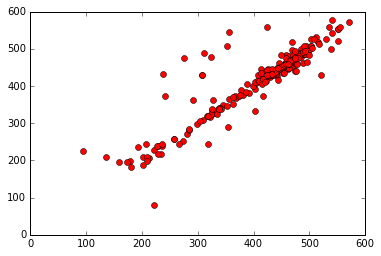

In [220]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

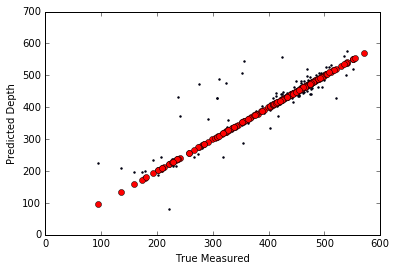

In [221]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [222]:
import pdvega
import vega

In [223]:
test_df_pred2

CALI     COND     DELT      DEPT   DPHI  DT  DistFrom_NN1_TopDepth       GR  GR_max_11winSize_dirabove  GR_max_11winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_5winSize_dirabove  GR_max_5winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_11winSize_dirabove  GR_mean_11winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_5winSize_dirabove  GR_mean_5winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_11winSize_dirabove  GR_min_11winSize_dirabove_n3  GR_min_11winSize_diraround  GR_min_11winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_5winSize_dirabove  GR_min_5winSize_dirabove_n3  GR_min_5winSize_diraround  GR_min_5winSize_diraround_n3  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  HorID  \
722       NaN      NaN      NaN  415.1960  0.187 NaN                 7.5540   90.535                     94.047                      92.964                    108.337                     104.498                    90.535                     92.664                    90.535                     92.664                   83.575091                    88.158545                   93.477952                    89.835238                    84.1518                     89.1242                  84.775571                   87.931714                     71.517                     90.812667                      78.015                      92.555000                     71.517                    107.986667                      71.517                     103.524333                    78.015                    87.001000                     82.612                     91.717667                    78.015                    88.623667                     78.015                     92.168000  13000   
624   220.520      NaN      NaN  344.9760  0.315 NaN                14.3840  134.925                    134.925                     163.206                    134.925                     163.206                   134.925                    163.206                   134.925                    163.206                   83.993364                   115.781818                   80.631524                    89.645429                   108.5494                    138.0286                  97.612714                  132.242857                     57.862                    122.183667                      73.367                     155.693000                     57.862                    122.183667                      52.787                     155.693000                    84.126                   122.183667                    109.776                    152.839000                    67.175                   122.183667                     92.070                    155.693000  13000   
521       NaN      NaN      NaN  280.2500  0.186 NaN                -4.2500   75.691                     75.691                     108.915                     87.900                     108.915                    75.691                     98.224                    75.691                    108.915                   55.416364                    71.940091                   66.634048                    67.728048                    56.4284                     76.3862                  52.536429                   76.352000                     37.063                     71.217333                      37.063                     102.054000                     37.063                     84.267333                      37.063                     102.054000                    37.063                    67.153667                     55.484                     85.387000                    37.063                    67.153667                     43.618                     96.461667  13000   
665       NaN      NaN      NaN  476.2500  0.

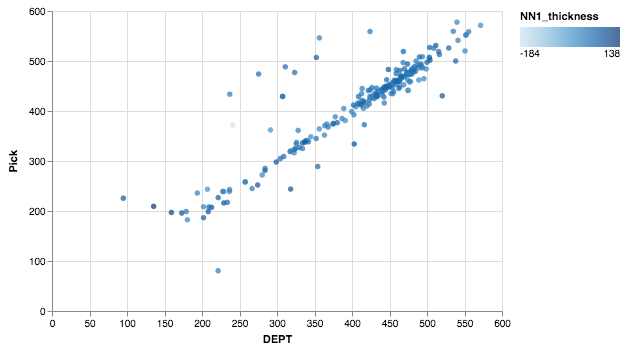

In [225]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

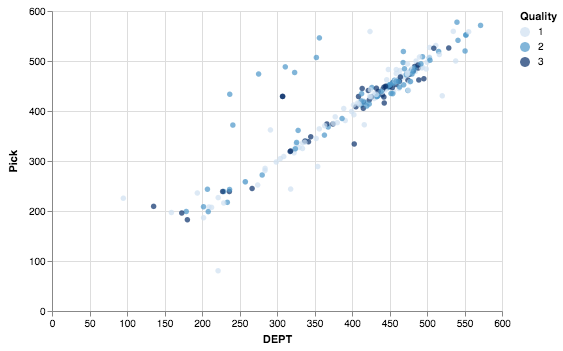

In [227]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='Quality')